## Occupational Ladders

Reminder: As a reminder, what we are interested in doing is creating a useful measure of "transition-ability" between occupations. So far, we have done this with the ONET related occupations network as a first step. However, we could consider detecting occupational ladders in the occupational mobility network and create links between higher-level occupations to lower-level occupations in the same occupational ladder. Below I do this using a pagerank algorithm displayed in a Sankey diagram as a first step. What I wish to discuss with Maria is either how to improve or replace this option. 

Agenda:
* Currently use a pagerank check to find "absorbing" occupations relative to others. This was with the help of ChatGPT 
* I imagine that another option might be better where-in we detect the most common paths from one occupation to another as a way of detecting an occupation ladder.



In [1]:
# Import packages
import numpy as np
from copy import deepcopy 
from network_input_builder import *
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import math as math
from pandas import Series
import os
import seaborn as sns
import matplotlib.gridspec as gridspec
import csv
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio

rng = np.random.default_rng()
test_fun()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/"

import os
print(os.cpu_count())


NEW Function import successful
8


First, we pull the full OMN network and the ONET networks along with their input data.

In [2]:
mod_dict = {}

for name in ['full_omn', 'onet']: #, "Full OMN Occupations"]:
    mod_data, net_temp, vacs, occ_ids, occ_shocks_dat = network_input_builder(name)
    if name == "onet":
        nw_title = "ONET Related Occupations"
    elif name == "original_omn":
        nw_title = "Original OMN Occupations"
    elif name == "full_omn":
        nw_title = "Full OMN Occupations"
    else:
        raise ValueError("Unknown network type")

    mod_dict[name] = {'network_label': nw_title,
                    'mod_data': mod_data,
                     'occ_ids': occ_ids}


Using Full Corrected OMN
(528, 528)
(528, 17)
(528, 2)
Build mod_data.
Nodes (n): 528
Using ONET Related Occupations Network
Build mod_data.
Nodes (n): 516
Initialised network.
(516, 112)


Then we create a tier-aggregated Sankey/flow diagram for each network.

For each network, the helper function build_sankey_inputs takes the transition matrices with the share of workers moving from occupation i to occupation j. We multiply these shares by each occupation’s total employment to obtain absolute employment flows.
It then constructs a directed graph from these flows and computes PageRank scores for all occupations.

"PageRank is a centrality measure originally developed for ranking web pages: a node’s score reflects not just how many connections it receives but also the importance of the nodes sending those connections.
Here, PageRank identifies occupations that are structurally central attractors of mobility, jobs that many other occupations feed into, especially if those source occupations themselves have substantial inflows.
In other words, higher-PageRank occupations are positions that workers tend to move toward and that play a key role in the network’s mobility structure."

Occupations are then grouped into quintiles of their PageRank scores, and all flows are aggregated between tiers rather than individual occupations.
Each Sankey diagram shows these aggregated flows:
	•	Nodes (tiers) represent groups of occupations from low- to high-centrality.
	•	Links represent the total employment moving from one tier to another, with line thickness proportional to the flow magnitude.
	•	Labels or hover text list example occupations within each tier.

Plotted in a vertical grid (one per network), these diagrams provide comparison of how mobility is structured across our two networks. They reveal whether labor flows tend to remain within the same centrality tier, or whether there is substantial upward or downward movement between low- and high-PageRank occupations—providing an intuitive picture of the occupational mobility hierarchy embedded in each network.

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
from typing import Dict, Any

def build_sankey_inputs(entry: Dict[str, Any],
                        n_tiers: int = 7,
                        display_counts: bool = True,
                        self_loops: bool = True,
                        link_threshold: float | None = None,
                        link_threshold_frac: float = 1e-6,
                        n_examples: int = 10,
                        sample_mode: str = "top",   # "top" or "random"
                        pagerank_alpha: float = 0.85) -> Dict[str, Any]:
    """
    Build and return a dict of inputs needed to plot a tier-aggregated Sankey for one network entry.

    Parameters
    ----------
    entry : dict
        A mod_dict[name] entry. Expected keys (flexible):
          - 'mod_data' : either a DataFrame (adjacency) or a dict containing key 'A' DataFrame
          - 'occ_ids'  : labels (Series / DataFrame single column / list)
          - optionally 'network_label', 'DISPLAY_COUNTS', etc.
    n_tiers : int
        Number of tiers to aggregate into.
    display_counts : bool
        True -> aggregate raw counts from M; False -> aggregate P (row-normalized probabilities).
    self_loops : bool
        If False, removes diagonal flows from the aggregated tier matrix.
    link_threshold : float|None
        If provided, absolute threshold (in same units as flows). If None, will use fraction of total.
    link_threshold_frac : float
        Fraction of total flow used when link_threshold is None.
    n_examples : int
        Number of example occupations per tier to include in labels.
    sample_mode : "top" or "random"
        "top" selects highest PageRank per tier; "random" chooses deterministic random sample.
    pagerank_alpha : float
        damping factor for PageRank

    Returns
    -------
    dict with keys:
      - 'M','P','labels','pr_scores','tiers','agg'
      - 'links_src','links_tgt','links_val','links_label'
      - 'tier_labels','node_x','node_y','node_colors'
      - 'examples_df','node_df'
    """
    # --- extract adjacency matrix ---
    mod_data = entry.get("mod_data")
    if mod_data is None:
        raise ValueError("entry must contain 'mod_data' key")

    # allow mod_data to be dict with 'A' or a DataFrame directly
    if isinstance(mod_data, dict) and "A" in mod_data:
        network_df = mod_data["A"]
    elif isinstance(mod_data, pd.DataFrame):
        network_df = mod_data
    else:
        try:
            network_df = pd.DataFrame(mod_data)
        except Exception:
            raise ValueError("Could not interpret entry['mod_data'] as a matrix-like object")

    M = network_df.values.astype(float)
    N = M.shape[0]
    if M.shape[0] != M.shape[1]:
        raise ValueError(f"Adjacency matrix must be square, got {M.shape}")

    # --- labels extraction (robust) ---
    occ_ids_obj = entry.get("occ_ids")
    occ_series = occ_ids_obj['label']
    labels = occ_series.tolist()

    # --- build row-normalized P ---
    P = np.zeros_like(M, dtype=float)
    row_sums = M.sum(axis=1)
    nonzero_rows = row_sums > 0
    P[nonzero_rows, :] = M[nonzero_rows, :] / row_sums[nonzero_rows, None]

    # --- build graph and compute PageRank on reversed graph ---
    G = nx.DiGraph()
    G.add_nodes_from(range(N))
    rows, cols = np.nonzero(P > 0)
    for i, j in zip(rows, cols):
        G.add_edge(int(i), int(j), weight=float(P[i, j]*mod_data['employment'].iloc[i]))

    if len(G) == 0:
        pr_scores = np.ones(N) / N
    else:
        G_rev = G.reverse(copy=True)
        pr = nx.pagerank(G_rev, alpha=pagerank_alpha, weight='weight')
        pr_scores = np.array([pr.get(i, 0.0) for i in range(N)], dtype=float)

    # --- tiers assignment (robust qcut) ---
    def make_exact_qtiers(values, q):
        try:
            tert, bins = pd.qcut(values, q=q, labels=False, retbins=True, duplicates='drop')
            if len(np.unique(tert)) < q:
                raise ValueError("qcut fewer bins")
            return np.asarray(tert, dtype=int)
        except Exception:
            ranks = pd.Series(values).rank(method='average')
            pct = (ranks - 0.5) / len(ranks)
            bins = np.linspace(0, 1, q+1)
            inds = np.digitize(pct, bins[1:-1], right=True)
            return inds.astype(int)

    tiers = make_exact_qtiers(pr_scores, n_tiers)
    tiers = np.clip(tiers, 0, n_tiers-1)

    # --- aggregate flows between tiers ---
    agg = np.zeros((n_tiers, n_tiers), dtype=float)
    source_matrix = M if display_counts else P
    for i in range(N):
        a = int(tiers[i])
        row = source_matrix[i, :]
        nonzero_j = np.nonzero(row > 0)[0]
        for j in nonzero_j:
            b = int(tiers[j])
            agg[a, b] += float(row[j])

    if not self_loops:
        np.fill_diagonal(agg, 0.0)

    # --- threshold links ---
    total_flow = float(agg.sum())
    if link_threshold is None:
        thresh = (link_threshold_frac * total_flow) if total_flow > 0 else 0.0
    else:
        thresh = float(link_threshold)

    links_src, links_tgt, links_val, links_label = [], [], [], []
    for a in range(n_tiers):
        for b in range(n_tiers):
            v = float(agg[a, b])
            if v <= thresh:
                continue
            links_src.append(int(a))
            links_tgt.append(int(b))
            links_val.append(v)
            if display_counts:
                pct = 100.0 * v / total_flow if total_flow > 0 else 0.0
                links_label.append(f"{int(v):,} ({pct:.2f}% of total)")
            else:
                pct = 100.0 * v / total_flow if total_flow > 0 else 0.0
                links_label.append(f"{v:.4f} ({pct:.2f}% of total)")

    # --- sample example occupations per tier ---
    def shorten(s, n=30):
        s = str(s)
        return s if len(s) <= n else s[:n-3] + "..."

    occ_series = pd.Series(labels).reset_index(drop=True)
    tier_examples = {}
    rng = np.random.RandomState(0)
    for t in range(n_tiers):
        nodes = np.where(tiers == t)[0].tolist()
        if len(nodes) == 0:
            tier_examples[t] = []
            continue
        if sample_mode == "top":
            nodes_sorted = sorted(nodes, key=lambda i: -float(pr_scores[i]))
            picked = nodes_sorted[:min(n_examples, len(nodes_sorted))]
        else:
            picked = list(rng.choice(nodes, size=min(n_examples, len(nodes)), replace=False))
        tier_examples[t] = [shorten(occ_series.iloc[i]) for i in picked]

    # --- build tier_labels (use <br> for Plotly) ---
    tier_in = agg.sum(axis=0)
    tier_out = agg.sum(axis=1)
    tier_labels = []
    for k in range(n_tiers):
        if display_counts:
            base = f"Tier {k+1}<br>out={int(tier_out[k]):,}<br>in={int(tier_in[k]):,}"
        else:
            base = f"Tier {k+1}<br>out={tier_out[k]:.4f}<br>in={tier_in[k]:.4f}"
        examples = tier_examples.get(k, [])
        if examples:
            ex_text = "<br>".join(examples)
            if len(ex_text) > 250:
                ex_text = ex_text[:247] + "..."
            label = f"{base}<br>Examples:<br>{ex_text}"
        else:
            label = base
        tier_labels.append(label)

    # --- node positions and colors (one node per tier) ---
    node_x = [k / max(1, (n_tiers - 1)) for k in range(n_tiers)]
    node_y = [0.5 for _ in range(n_tiers)]
    denom = (n_tiers - 1) if n_tiers > 1 else 1
    node_colors = [
        f"rgb({int(255*(1 - k/denom))},{int(255*(1 - k/denom))},{int(255*(1 - k/denom))})"
        for k in range(n_tiers)
    ]

    # --- produce node_df and examples_df for inspection ---
    node_df = pd.DataFrame({
        "node_index": np.arange(N),
        "label": labels,
        "pagerank_rev": pr_scores,
        "tier": tiers
    })

    ex_rows = []
    for t, names in tier_examples.items():
        for pos, name_ in enumerate(names, start=1):
            ex_rows.append({"tier": t+1, "rank_in_tier": pos, "occupation": name_})
    examples_df = pd.DataFrame(ex_rows)

    return {
        "M": M, "P": P, "labels": labels, "pr_scores": pr_scores, "tiers": tiers, "agg": agg,
        "links_src": links_src, "links_tgt": links_tgt, "links_val": links_val, "links_label": links_label,
        "tier_labels": tier_labels, "node_x": node_x, "node_y": node_y, "node_colors": node_colors,
        "node_df": node_df, "examples_df": examples_df, "network_label": entry.get("network_label", "")
    }



The first interesting insight is that the ONET, perhaps as expected sees a much more balanced diagram (ie. majority of flows in the OMN are flowing upward).

In [4]:
from math import ceil
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# ---------- loop over networks and plot ----------
examples = True

# choose how many columns (plots per row)
cols = 1              # e.g., 2 side-by-side
names = list(mod_dict.keys())
n = len(names)
rows = len(mod_dict)

# flag: show examples inside node labels (True) or keep labels short and put examples in hovertext (False)
examples = True

# Collect inputs for all networks first (so we can inspect link counts etc.)
inputs_list = []
for name, entry in mod_dict.items():
    inputs = build_sankey_inputs(entry,
                                 n_tiers=7,
                                 display_counts=True,
                                 self_loops=False,
                                 n_examples=8,
                                 sample_mode="top")
    inputs["name"] = name
    inputs_list.append(inputs)

# create subplot figure with domain-type cells (suitable for sankey traces)
specs = [[{"type": "domain"} for _ in range(cols)] for _ in range(rows)]
fig = make_subplots(rows=rows, cols=cols, specs=specs,
                    subplot_titles=[f"{inp['network_label']}" for inp in inputs_list] + [""]*(rows*cols - len(inputs_list)))

# add a sankey into each subplot cell
for idx, inputs in enumerate(inputs_list):
    r = (idx // cols) + 1
    c = (idx % cols) + 1

    if examples:
        # full labels (tier_labels already contains <br> for line breaks)
        sankey = go.Sankey(
            arrangement="snap",
            node=dict(
                pad=15,
                thickness=18,
                line=dict(color="black", width=0.5),
                label=inputs["tier_labels"],
                x=inputs["node_x"],
                y=inputs["node_y"],
                color=inputs["node_colors"]
            ),
            link=dict(
                source=inputs["links_src"],
                target=inputs["links_tgt"],
                value=inputs["links_val"],
                label=inputs["links_label"],
                hovertemplate='%{label}<br>Value: %{value}<extra></extra>'
            )
        )
    else:
        # short labels + examples in customdata/hovertemplate
        short_labels = [f"Tier {k+1}\n(out={int(inputs['agg'].sum(axis=1)[k]):,})" for k in range(len(inputs['tier_labels']))]
        hover_examples = []
        for k in range(len(inputs['tier_labels'])):
            exs = inputs['examples_df'].loc[inputs['examples_df']['tier'] == (k+1), 'occupation'].tolist()
            hover_examples.append("<br>".join([f"<b>Examples:</b>"] + exs) if exs else "")
        sankey = go.Sankey(
            arrangement="snap",
            node=dict(
                pad=15,
                thickness=18,
                line=dict(color="black", width=0.5),
                label=short_labels,
                x=inputs["node_x"],
                y=inputs["node_y"],
                color=inputs["node_colors"],
                customdata=hover_examples,
                hovertemplate='%{customdata}<extra></extra>'
            ),
            link=dict(
                source=inputs["links_src"],
                target=inputs["links_tgt"],
                value=inputs["links_val"],
                hovertemplate='%{label}<br>Value: %{value}<extra></extra>'
            )
        )

    # add the sankey trace to the subplot cell
    fig.add_trace(sankey, row=r, col=c)

# layout sizing: adjust width/height per number of cols/rows
fig.update_layout(
    title_text="Tier-aggregated Sankeys",
    font_size=11,
    height=400 * rows,    # tweak multiplier to adjust vertical size
    width=2500
)

# show (with fallback HTML file)
try:
    fig.show()
except Exception as e:
    outname = "sankey_grid_output.html"
    fig.write_html(outname, include_plotlyjs='cdn')
    print("Renderer couldn't show inline; wrote:", outname)

/var/folders/34/6r0xdq916zn1qsvypkxnsqkw0000gr/T/ipykernel_11761/3136264228.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  G.add_edge(int(i), int(j), weight=float(P[i, j]*mod_data['employment'].iloc[i]))
/var/folders/34/6r0xdq916zn1qsvypkxnsqkw0000gr/T/ipykernel_11761/3136264228.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  G.add_edge(int(i), int(j), weight=float(P[i, j]*mod_data['employment'].iloc[i]))


Below, I plot the outgoing transition rates from each occupation where the nodes are ordered by wages so that we can compare the ONET and OMN networks. 

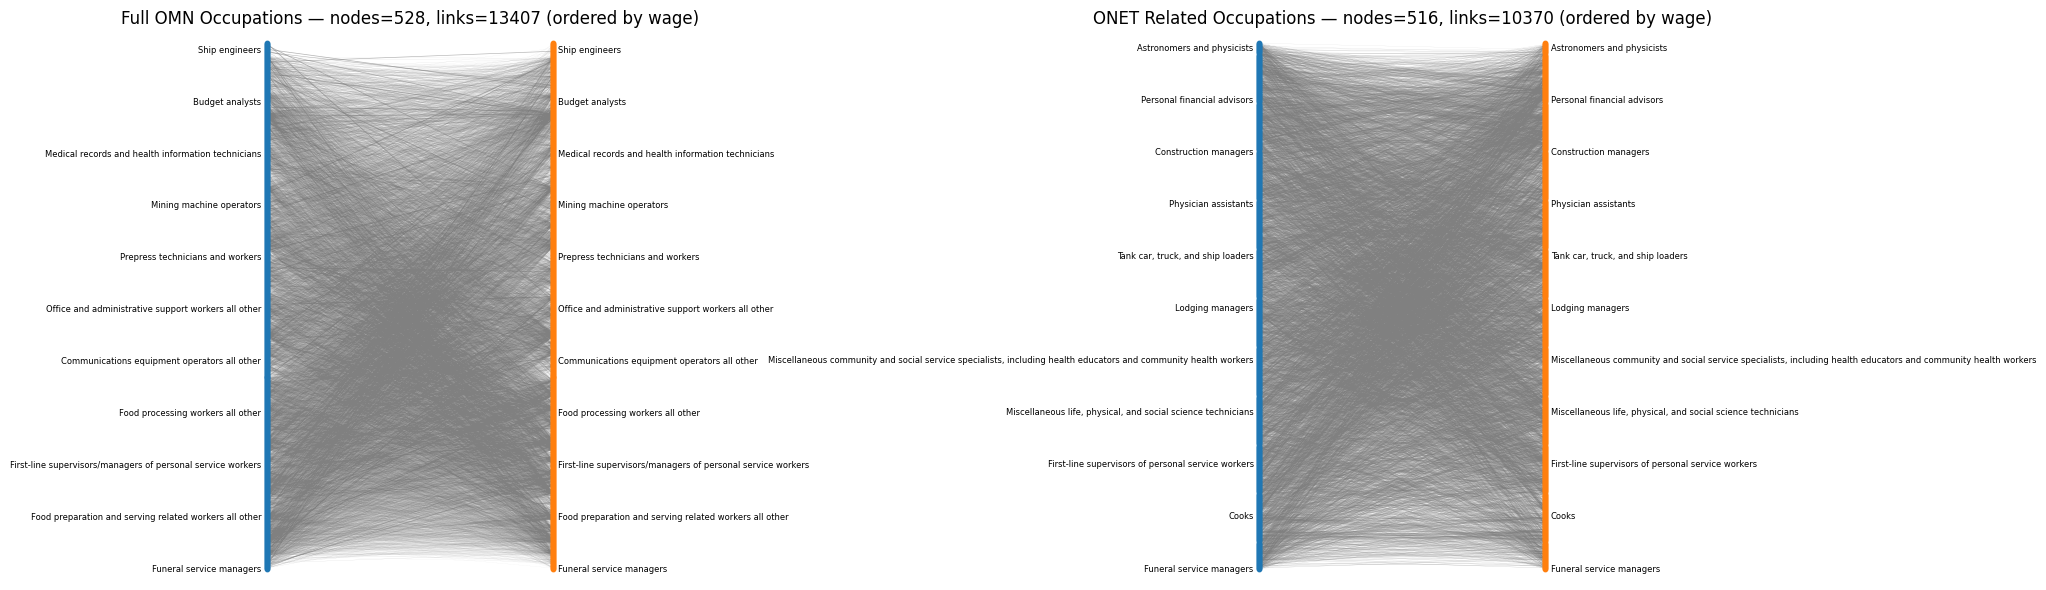

In [ ]:
# Layout: change columns to control how many plots per row
names = list(mod_dict.keys())
n = len(names)
cols = 2                 # plots per row (set 1/2/3 ...)
rows = math.ceil(n / cols)

# Figure size (tweak per-column width and per-row height)
width_per_col = 10
height_per_row = 6
fig_w = cols * width_per_col
fig_h = rows * height_per_row
fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False)

# plotting settings (you already used)
DISPLAY_COUNTS = True
TOP_K_PER_ORIGIN = None
LINK_THRESHOLD_FRAC = 1e-9
MIN_LW, MAX_LW = 0.3, 6.0

for idx, name in enumerate(names):
    ax = axes[idx // cols, idx % cols]
    entry = mod_dict[name]

    # --- load matrix and labels ---
    M_nw = np.array(entry.get("mod_data")['A'])
    N = M_nw.shape[0]
    labels = entry.get("occ_ids")['label'].tolist()
    assert len(labels) == N
    # remove self-loops
    np.fill_diagonal(M_nw, 0.0)

    # --- read wages and compute order ---
    wages = entry.get("mod_data")['wages']
    # handle DataFrame or Series; pick first column if DataFrame
    if isinstance(wages, np.ndarray):
        w = wages.ravel().astype(float)
    else:
        w = wages.iloc[:, 0].to_numpy().astype(float)
    order = np.argsort(w)  # lowest -> highest

    # reorder matrix & labels
    M_sorted = M_nw[order][:, order]
    labels_sorted = [labels[i] for i in order]

    # we'll plot the "without self-loops" version
    src = M_sorted.astype(float)
    total = src.sum()
    abs_thresh = (LINK_THRESHOLD_FRAC * total) if total > 0 else 0.0

    # node positions (y in [0,1], wage order low->high)
    pad = 0.02
    ys = np.linspace(pad, 1 - pad, N)
    left_x = np.zeros(N)
    right_x = np.ones(N)

    # collect links (top-k logic kept)
    links = []
    for i in range(N):
        row = src[i]
        nz = np.nonzero(row > abs_thresh)[0]
        if nz.size == 0:
            continue
        vals = [(int(j), float(row[j])) for j in nz]
        vals.sort(key=lambda x: -x[1])
        if TOP_K_PER_ORIGIN is not None:
            vals = vals[:TOP_K_PER_ORIGIN]
        for j, v in vals:
            links.append((i, j, v))

    # If no links, place a message and continue
    if len(links) == 0:
        ax.text(0.5, 0.5, "No links to plot", ha="center", va="center")
        ax.axis("off")
        continue

    # linewidth scaling
    vals = np.array([v for _, _, v in links])
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        lws = np.full_like(vals, (MIN_LW + MAX_LW) / 2)
    else:
        lws = MIN_LW + (vals - vmin) / (vmax - vmin) * (MAX_LW - MIN_LW)

    # draw on axis
    ax.set_xlim(-0.12, 1.12)
    ax.set_ylim(0, 1)
    ax.axis("off")

    ax.scatter(left_x, ys, s=10, color="C0", zorder=3)
    ax.scatter(right_x, ys, s=10, color="C1", zorder=3)

    for (i, j, v), lw in zip(links, lws):
        ax.plot([0.0, 1.0], [ys[i], ys[j]], linewidth=lw / 10, alpha=0.6, color="gray", zorder=1)

    # annotate a few labels (sparse)
    for label_idx in range(0, N, max(1, N // 10)):  # ~10 labels evenly spaced
        ax.text(-0.02, ys[label_idx], labels_sorted[label_idx], va="center", ha="right", fontsize=6)
        ax.text(1.02, ys[label_idx], labels_sorted[label_idx], va="center", ha="left", fontsize=6)

    ax.set_title(f"{entry.get('network_label')} — nodes={N}, links={len(links)} (ordered by wage)")

# hide unused axes if n < rows*cols
total_plots = rows * cols
if n < total_plots:
    for k in range(n, total_plots):
        ax = axes[k // cols, k % cols]
        ax.axis("off")

plt.tight_layout()
plt.show()

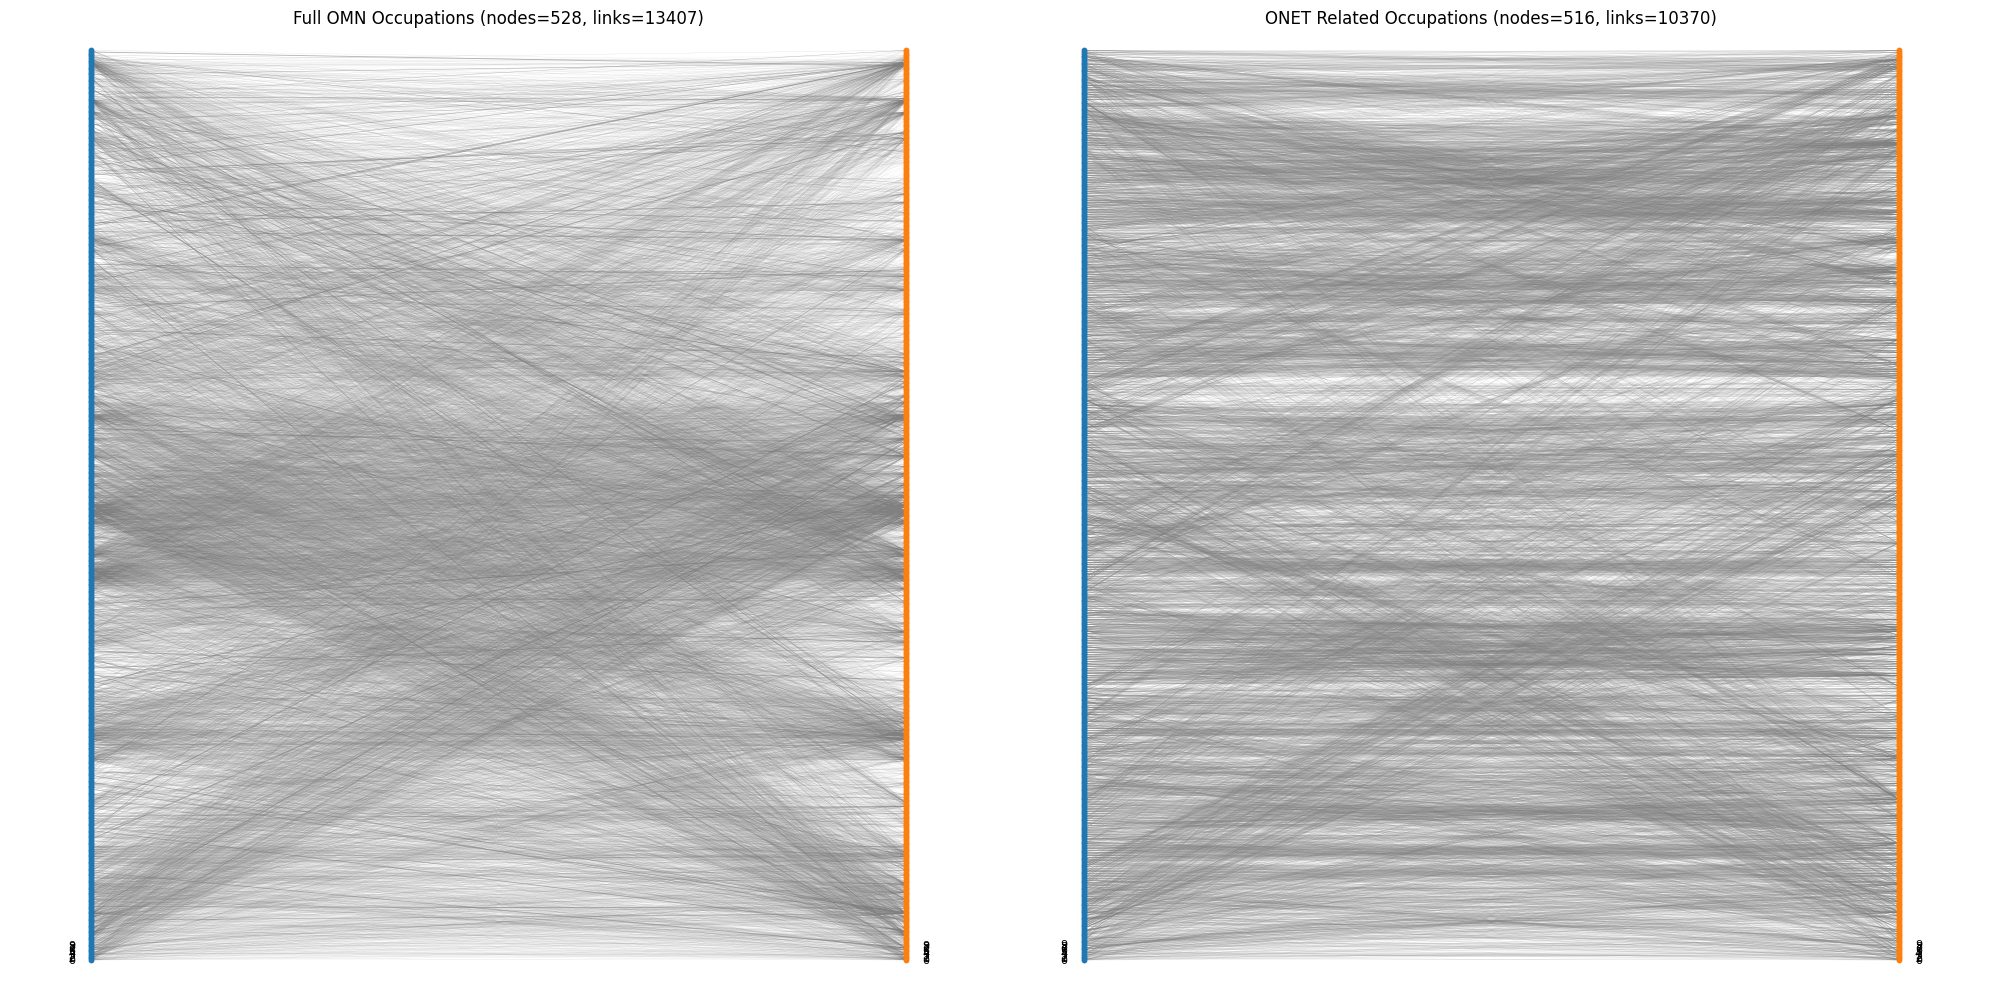

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt

# --- settings you already had ---
DISPLAY_COUNTS = True
TOP_K_PER_ORIGIN = None
LINK_THRESHOLD_FRAC = 1e-9
MIN_LW, MAX_LW = 0.3, 6.0

# Layout for multiple plots
names = list(mod_dict.keys())
n = len(names)
cols = 2
rows = math.ceil(n / cols)
# size: width per column ~10, height per row ~6 (tweak as needed)
fig_w = cols * 10
fig_h = rows * 10
fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False)

for idx, name in enumerate(names):
    ax = axes[idx // cols, idx % cols]

    entry = mod_dict[name]
    M_nw = np.array(entry.get("mod_data")['A'])
    N = M_nw.shape[0]
    labels = entry.get("occ_ids")['label'].tolist()
    assert len(labels) == N
    np.fill_diagonal(M_nw, 0.0)

    # pick source matrix
    src = M_nw.astype(float)
    total = src.sum()
    abs_thresh = (LINK_THRESHOLD_FRAC * total) if total > 0 else 0.0

    # node positions
    pad = 0.02
    ys = np.linspace(pad, 1-pad, N)
    left_x = np.zeros(N)
    right_x = np.ones(N)

    # collect links
    links = []
    for i in range(N):
        row = src[i]
        nz = np.nonzero(row > abs_thresh)[0]
        if nz.size == 0:
            continue
        vals = [(int(j), float(row[j])) for j in nz]
        vals.sort(key=lambda x: -x[1])
        if TOP_K_PER_ORIGIN is not None:
            vals = vals[:TOP_K_PER_ORIGIN]
        for j, v in vals:
            links.append((i, j, v))

    if len(links) == 0:
        ax.text(0.5, 0.5, "No links to plot", ha="center", va="center")
        ax.axis("off")
        continue

    # scale linewidths
    vals = np.array([v for _, _, v in links])
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        lws = np.full_like(vals, (MIN_LW + MAX_LW) / 2)
    else:
        lws = MIN_LW + (vals - vmin) / (vmax - vmin) * (MAX_LW - MIN_LW)

    # draw on this axis
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    ax.scatter(left_x, ys, s=10, color='C0', zorder=3)
    ax.scatter(right_x, ys, s=10, color='C1', zorder=3)

    for (i, j, v), lw in zip(links, lws):
        ax.plot([0.0, 1.0], [ys[i], ys[j]], linewidth=lw/10, alpha=0.6, color='gray', zorder=1)

    # annotate a few labels (optional)
    for idx_label in range(min(10, N)):
        ax.text(-0.02, ys[idx_label], str(idx_label), va='center', ha='right', fontsize=8)
        ax.text(1.02, ys[idx_label], str(idx_label), va='center', ha='left', fontsize=8)

    ax.set_title(f"{entry.get('network_label')} (nodes={N}, links={len(links)})")

# hide any unused axes
total_plots = rows * cols
if n < total_plots:
    for k in range(n, total_plots):
        ax = axes[k // cols, k % cols]
        ax.axis('off')

plt.tight_layout()
plt.show()